## This notebook walks us through the process of generating the database of all possible hex maze configurations.

In [35]:
# General imports we need
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm

### Step 1: Generate a bunch of valid maze configurations
We start by using a naive generation approach (randomly generating possible barrier sets until we get a valid maze) to generate 100,000 valid hex maze configurations. We'll store them in a set to remove duplicates.

In [ ]:
from hex_maze_utils import generate_good_maze

# Initialize a set to store all of the unique maze configurations we generate
valid_maze_configs = set()

# Initialize a list to track how many unique configurations we have after
# every 100 configurations we randomly generate. Watching this list reach an 
# asymptote will give us info on how many unique configurations exist
number_of_valid_configs = []

# Generate 100,000 valid mazes
num_mazes_to_generate = 100000

for i in tqdm(range(1, num_mazes_to_generate+1)):
    # Randomly generate a valid maze configuration
    maze = frozenset(generate_good_maze())
    
    # Add the valid maze config to our set (this automatically removes any duplicates)
    valid_maze_configs.add(maze)
    
    # For every 100 configurations we generate, record how many are unique
    if i % 100 == 0: 
        num_valid = len(valid_maze_configs)
        number_of_valid_configs.append(num_valid)
        print(f"After {i} good mazes, {num_valid} are unique.")

We may realize that we didn't actually generate enough configurations to get all possible unique mazes. Here's the another version of the above cell but now we're loading our existing set and adding to that instead of starting from scratch.

In [ ]:
from hex_maze_utils import generate_good_maze

# Load our saved set of all unique maze configurations we've generated so far
with open('example_data/valid_maze_configs.pkl', 'rb') as file:
    valid_maze_configs = pickle.load(file)

# Load our saved list tracking how many unique configurations we have for
# every 100 configurations we randomly generate.
with open('example_data/number_of_valid_configs.pkl', 'rb') as file:
    number_of_valid_configs = pickle.load(file)

# Calculate how many mazes we've already generated based on the length of our saved list
num_mazes_generated = len(number_of_valid_configs)*100

# Generate another 10,000 valid mazes
num_mazes_to_generate = 10000

for i in tqdm(range(1, num_mazes_to_generate+1)):
    # Randomly generate a valid maze configuration
    maze = frozenset(generate_good_maze())
    
    # Add the valid maze config to our set (this automatically removes any duplicates)
    valid_maze_configs.add(maze)
    
    # For every 100 configurations we generate, record how many are unique
    if i % 100 == 0: 
        num_valid = len(valid_maze_configs)
        number_of_valid_configs.append(num_valid)
        print(f"After {num_mazes_generated+i} good mazes, {num_valid} are unique.")

Now that we've generated a bunch of mazes, save them so we don't have to do it again.

In [36]:
save = False # be warned that saving these will overwrite already saved files of the same name
# (I have added _DUPLICATE at the end of the file name as an extra check to prevent this)

if save:
    # Save our set of valid maze configurations to a pickle file
    with open('example_data/valid_maze_configs_DUPLICATE.pkl', 'wb') as file:
        pickle.dump(valid_maze_configs, file)
    
    # Also save the stats to a pickle file
    with open('example_data/number_of_valid_configs_DUPLICATE.pkl', 'wb') as file:
        pickle.dump(number_of_valid_configs, file)  

Now let's use the stats we kept track of during the maze generation process (how many unique mazes we have after every 100 valid mazes we randomly generate) to estimate how many unique maze configurations there are.

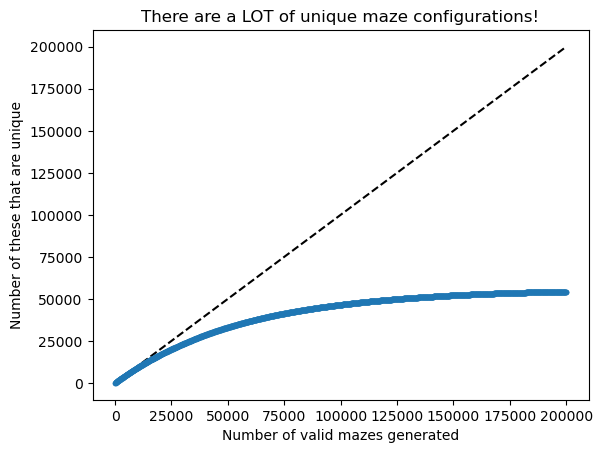

In [37]:
# Load our saved list tracking how many unique configurations we have for
# every 100 configurations we randomly generate.
with open('example_data/number_of_valid_configs.pkl', 'rb') as file:
    num_valid_configs = pickle.load(file)

# Set up our x axis (we recorded the number of unique configs after every 100 tries)
num_tries = list(range(0, len(num_valid_configs)*100, 100))

# Plot a unity line for comparison (if all mazes we generated were unique, our data should look like this)
plt.plot([0, num_tries [-1]], [0, num_tries[-1]], 'k--')

# Plot how many mazes we actually get
plt.plot(num_tries, num_valid_configs, '.')
plt.xlabel("Number of valid mazes generated")
plt.ylabel("Number of these that are unique")
plt.title("There are a LOT of unique maze configurations!")
plt.show()

Great! It looks like we're beginning to reach an asymptote. 


But we want to make sure ALL possible maze configurations are in our database. If we keep randomly generating configurations and hoping they are unique, this could take a really long time.

We can fill in the rest of the database by taking advantage of the fact that each maze has 5 other associated barrier sets that have the same graph structure (corresponding to the maze rotated clockwise/counterclockwise and reflected across its 3 axes of symmetry). In other words, each maze has 5 other mazes that it is isomorphic to/mazes can be divided into groups of 6 that are isomorphic. Based on the asymptote we see above, it seems likely that at least 1 of the 6  possible configurations for each group of isomorphic mazes exists in our set.

Let's see if this is true.

In [38]:
from hex_maze_utils import num_isomorphic_mazes_in_set

# Load our saved set of valid maze configurations
with open('example_data/valid_maze_configs.pkl', 'rb') as file:
    valid_mazes = pickle.load(file)

print(f"We have {len(valid_mazes)} unique maze configurations in our set.")

# Set up a list tracking the number of isomorphic mazes present for each maze 
# in the set of valid mazes. This will help us confirm our hypothesis that each 
# maze already has a number of isomorphic mazes present in our set
num_isomorphic_mazes_for_this_maze = []

# Initialize a set for all valid maze configurations that don't yet exist in our set
valid_mazes_not_in_set = set()

print("Checking how many isomorphic mazes exist for each maze in the set (and how many are missing) ... ")
for barrier_set in tqdm(valid_mazes):
    # For each maze in our set, find all isomorphic mazes for this configuration that 
    # already exist in our larger set, and which (if any) are missing.
    num_iso_mazes, missing_mazes = num_isomorphic_mazes_in_set(valid_mazes, barrier_set)
    
    # Record how many isomorphic mazes this maze has in the set
    num_isomorphic_mazes_for_this_maze.append(num_iso_mazes)
    
    # If we found valid maze configurations that don't yet exist in our larger set, add them here
    for maze in missing_mazes:
        valid_mazes_not_in_set.add(maze)
        
print(f"We found {len(valid_mazes_not_in_set)} unique maze configurations not in our original set.")

We have 54355 unique maze configurations in our set.
Checking how many isomorphic mazes exist for each maze in the set (and how many are missing) ... 


100%|████████████████████████████████████| 54355/54355 [01:22<00:00, 660.35it/s]

We found 1541 unique maze configurations not in our original set.


Using this data, we can plot a histogram of how many isomorphic mazes exist for each maze in our set.

If most mazes have 4 or 5, it seems fairly likely that our set contains at least one maze for each set of 6 isomorphic mazes (meaning we can complete our set simply by adding these missing isomorphic mazes). 

If we have a lot of mazes with only 0-2 isomorphic mazes in the set, it is possible we are missing some entire groups of isomorphic mazes (meaning we should go back and generate some more mazes to make sure we get them all).

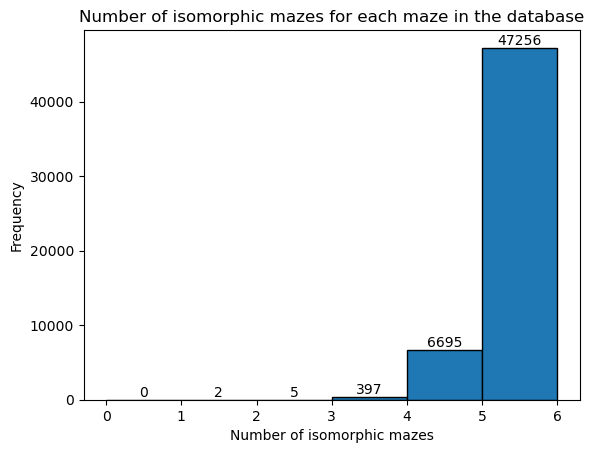

In [39]:
bin_edges = range(7)  # A maze could have 0, 1, 2, 3, 4, or 5 isomorphic mazes in the set

# Plot histogram of how many isomorphic mazes exist in the database for each maze
n, bins, patches = plt.hist(num_isomorphic_mazes_for_this_maze, bins=bin_edges, edgecolor='black')

# Add title and labels
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for count, x in zip(n, bin_centers):
    plt.text(x, count, str(int(count)), ha='center', va='bottom')
#plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], [0, 1, 2, 3, 4, 5])
plt.title('Number of isomorphic mazes for each maze in the database')
plt.xlabel('Number of isomorphic mazes')
plt.ylabel('Frequency')
plt.show()

This looks pretty good! Most of the isomorphic mazes for each maze are already in the set. 

By adding the few that we missed, our set should be (at least close to) complete.

### Step 2: Complete the set by ensuring all isomorphic maze configurations are present

In [40]:
# Now let's create a combined database with (hopefully) all possible hex maze configurations

print(f"We had {len(valid_mazes)} unique maze configurations in our set.")
print(f"We found {len(valid_mazes_not_in_set)} unique maze configurations not in our original set.")

# Add the newly generated mazes to our set
valid_mazes.update(valid_mazes_not_in_set)

print(f"We now have {len(valid_mazes)} unique maze configurations in our set.")

save = False # be warned that saving will overwrite already saved files of the same name
# (I have added _DUPLICATE at the end of the file name as an extra check to prevent this)

if save:
    # Save our combined set of valid maze configurations to a pickle file
    with open('example_data/all_valid_maze_configs_DUPLICATE.pkl', 'wb') as file:
        pickle.dump(valid_mazes, file) 

We had 54355 unique maze configurations in our set.
We found 1541 unique maze configurations not in our original set.
We now have 55896 unique maze configurations in our set.


### Step 3: Store these in a database with attributes for each maze

Now that we have a bunch of valid maze configurations, how do we choose which one(s) to use in our experiments?

Depending on what we are trying to test, we may want mazes with certain path lengths between reward ports, certain numbers of choice points, a choice point specifically at hex 13, etc. We might (or might not) want mazes that have multiple optimal paths between reward ports, or configurations that allow the rat to travel in a circle without turning around. We'll calculate all of these attributes (and more!) for each maze and store them alongside the maze in the database, so it's easy to search for the exact kind of mazes we want.

In [41]:
from hex_maze_utils import get_maze_attributes

# Load our saved set of all valid maze configurations
with open('example_data/all_valid_maze_configs.pkl', 'rb') as file:
    all_valid_mazes = pickle.load(file)
    
# Convert it to a list so we can iterate
all_mazes = list(all_valid_mazes)
print(f"We have {len(all_mazes)} maze configurations to add to our database.")

maze_dicts = []
# Calculate info for each maze and add it to our dictionary
for maze in tqdm(all_mazes):
    maze_attributes = get_maze_attributes(maze)
    maze_dicts.append(maze_attributes)

# Create DataFrame
maze_configuration_database = pd.DataFrame(maze_dicts)

print("Here is our database!")
display(maze_configuration_database)

We have 55896 maze configurations to add to our database.


100%|███████████████████████████████████| 55896/55896 [00:24<00:00, 2300.34it/s]


Here is our database!


,barriers,len12,len13,len23,reward_path_lengths,path_length_difference,optimal_paths_12,optimal_paths_13,optimal_paths_23,optimal_paths_all,choice_points,num_choice_points,cycles,num_cycles,isomorphic_mazes
0,"(37, 7, 39, 41, 14, 46, 20, 23, 30)",15,17,21,"[15, 17, 21]",6,"[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 1...","[[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, ...",{13},1,[],0,"{(37, 8, 40, 9, 20, 21, 22, 27, 28), (32, 34, ..."
1,"(34, 36, 37, 39, 10, 45, 14, 15, 20)",17,21,19,"[17, 21, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 25, 30, 3...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 22, 2...",{21},1,[],0,"{(34, 37, 8, 40, 10, 15, 18, 20, 26), (34, 35,..."
2,"(34, 7, 41, 11, 46, 17, 20, 28, 31)",23,19,17,"[23, 19, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 25, 30, 35, 4...","[[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, ...",{35},1,"[[38, 49, 47, 42, 37, 32]]",1,"{(35, 7, 10, 44, 20, 22, 27, 28, 31), (32, 37,..."
3,"(34, 10, 42, 12, 45, 18, 23, 25, 31)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 22, 27, 32, ...",{17},1,[],0,"{(34, 37, 8, 40, 13, 46, 15, 18, 25), (34, 37,..."
4,"(39, 9, 10, 46, 21, 22, 23, 26, 30)",23,17,17,"[23, 17, 17]",6,"[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...",{29},1,"[[32, 38, 49, 47, 42, 37], [12, 15, 19, 24, 20...",2,"{(34, 36, 8, 41, 9, 21, 23, 27, 30), (10, 42, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55891,"(34, 36, 7, 10, 42, 46, 19, 22, 25)",15,19,21,"[15, 19, 21]",6,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...","[[1, 4, 6, 8, 11, 14, 17, 13, 16, 20, 24, 29, ...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 37, 32, ...",{17},1,[],0,"{(34, 37, 7, 40, 9, 42, 14, 16, 25), (34, 37, ..."
55892,"(37, 7, 9, 13, 45, 16, 22, 25, 29)",17,19,15,"[17, 19, 15]",4,"[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 30, ...","[[2, 49, 47, 42, 46, 41, 36, 30, 35, 40, 44, 3...","[[1, 4, 6, 8, 11, 14, 17, 21, 26, 31, 36, 41, ...",{36},1,"[[34, 28, 33, 48, 43, 39]]",1,"{(32, 34, 40, 13, 15, 25, 26, 27, 31), (36, 10..."
55893,"(39, 7, 46, 17, 19, 22, 23, 24, 30)",17,23,17,"[17, 23, 17]",6,"[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...","[[2, 49, 38, 32, 37, 31, 36, 41, 45, 40, 35, 2...","[[1, 4, 6, 8, 10, 13, 16, 20, 25, 21, 26, 31, ...",{31},1,"[[32, 38, 49, 47, 42, 37]]",1,"{(32, 36, 7, 40, 11, 14, 17, 20, 23), (32, 36,..."
55894,"(34, 10, 11, 42, 45, 15, 22, 25, 30)",17,15,19,"[17, 15, 19]",4,"[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...","[[1, 4, 5, 7, 9, 12, 16, 20, 24, 19, 23, 28, 3...","[[2, 49, 38, 32, 37, 31, 26, 21, 17, 13, 16, 2...","[[1, 4, 5, 7, 9, 12, 16, 13, 17, 21, 26, 31, 3...",{16},1,"[[19, 23, 28, 33, 48, 43, 39, 44, 40, 35, 29, ...",1,"{(34, 37, 8, 12, 45, 18, 21, 23, 25), (37, 40,..."


Let's save our database for later use. Now that the database has been created, we can just load it whenever we want and we shouldn't need to run this notebook again (unless we want to generate a new database using different criteria for what constitutes a "valid" hex maze). 

In [31]:
save = False # be warned that saving will overwrite already saved files of the same name
# (I have added _DUPLICATE at the end of the file name as an extra check to prevent this)

if save:
    # Save the database as a CSV for readability without loading in a notebook
    maze_configuration_database.to_csv('maze_configuration_database_DUPLICATE.csv', index=False)
    
    # And also using pickle - this is better for loading in notebooks
    maze_configuration_database.to_pickle('maze_configuration_database_DUPLICATE.pkl')

Here's how to load the database for use in your notebooks! 

IMPORTANT: Make sure to load the pickle (.pkl) version instead of the csv (.csv) version - the csv version loads variables as strings and messes things up. 

In [42]:
# Loads the database as "df"
df = pd.read_pickle('maze_configuration_database.pkl')